# Explore Re-weighting Schemes
Our TD-DFT data is heavily biased. We only have a small amount of it, and it is collected along fixed vectors in the search space. As a result, our model is biased. In these notebooks, we explore whether we can re-weight the training data according to this bias in order to make a less-biased model.

For this notebook, our goal is to implement a few strategies for re-weighting the data and will test the weightings in a different notebook

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity, NearestNeighbors
import pickle as pkl
import pandas as pd
import numpy as np
import gzip
import os

## Load in the Target Space and Training Data
The sample space produced in the manifold task can be used to describe out search space

In [2]:
target_space = pd.read_pickle(os.path.join('..', 'sampled_space.pkl.gz'))
print('Imported a target space of {} entries'.format(len(target_space)))

Imported a target space of 16384 entries


In [3]:
train_data = pd.read_pickle(os.path.join('..', '..', 'data', 'random_data.pkl.gz')).query('not initial')
print('Imported a training set of {} entries'.format(len(train_data)))

Imported a training set of 9379 entries


In [4]:
with open(os.path.join('..', 'manifold_features.pkl'), 'rb') as fp:
    manifold_features = pkl.load(fp)

In [5]:
with gzip.open(os.path.join('..', 'manifold.pkl.gz')) as fp:
    manifold = pkl.load(fp)

## Reweight Based on Sample Density Estimates
We can use Kernel Density Measurements to develop a probability distribution of the sampled and training data. Then, the optimal weight for the training data is the ratio between the new probability distribution at that point

In [6]:
def get_average_nn_dist(dataset, n=10):
    """Get the average nearest neighbor distance for a dataset
    
    Args:
        dataset (pd.DataFrame): Dataset in question
    Returns:
        (float) The average NN distance
    """
    return NearestNeighbors(n_neighbors=2).fit(dataset).kneighbors(dataset)[0].max(axis=1).mean()

Train the kernel density estimator for the training set and target space. Use the average NN distance as the bandwidth for the kernel

In [7]:
train_kde = KernelDensity(bandwidth=get_average_nn_dist(train_data[manifold_features]) * 2).fit(train_data[manifold_features])

In [8]:
target_kde = KernelDensity(bandwidth=get_average_nn_dist(target_space[manifold_features]) * 2).fit(target_space[manifold_features])

Score each entry in the training dataset with both distributions

In [9]:
%%time
train_scores = train_kde.score_samples(train_data[manifold_features])

CPU times: user 4.53 s, sys: 19.6 ms, total: 4.54 s
Wall time: 4.52 s


In [10]:
%%time
target_scores = target_kde.score_samples(train_data[manifold_features])

CPU times: user 14.2 s, sys: 109 ms, total: 14.3 s
Wall time: 14.1 s


The desired weight is $Target(X)/Train(X)$. The score samples use the log values. So, the weight is equal to $e^{log(Target) - log(Train)}$

In [11]:
train_data['kde_weight'] = np.exp(target_scores - train_scores)

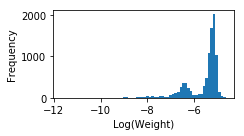

In [12]:
fig, ax = plt.subplots()

ax.hist(np.log10(train_data['kde_weight']), bins=64)

ax.set_xlabel('Log(Weight)')
ax.set_ylabel('Frequency')

fig.set_size_inches(3.5, 2)
fig.tight_layout()

*Note*: Setting the kernel width was an iterative process. I adjusted it until I had somehwat smooth points on the plot below. The thought was I did not want the Kernel to be too small

### Analyze Weights
What kind of entries are we weighing higher?

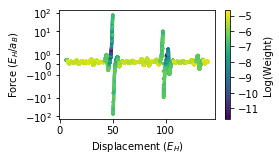

In [15]:
fig, ax = plt.subplots()

line = ax.scatter(train_data['displacement'], train_data['force'], c=np.log10(train_data['kde_weight']), s=5)

ax.set_yscale('symlog')

ax.set_ylabel('Force ($E_H / a_B$)')
ax.set_xlabel('Displacement ($E_H$)')

cax = fig.colorbar(line)
cax.set_label('Log(Weight)')
fig.set_size_inches(3.5, 2)
fig.savefig(os.path.join('figures', 'random-traj-kde-weights.png'), dpi=320)

*Finding*: We weight the channel portions higher than the impacts

## Save the Weights
Our next notebook will be to use them to train a model

In [14]:
train_data.to_pickle(os.path.join('data', 'random_data.pkl.gz'))